### House pricing model


*Getting the data ready*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer


In [13]:
pip install category_encoders

  Using cached category_encoders-2.8.1-py3-none-any.whl.metadata (7.9 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_10_13_x86_64.whl.metadata (31 kB)
  Using cached statsmodels-0.14.4-cp312-cp312-macosx_10_13_x86_64.whl.metadata (9.2 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached category_encoders-2.8.1-py3-none-any.whl (85 kB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_10_13_x86_64.whl (12.1 MB)
Using cached statsmodels-0.14.4-cp312-cp312-macosx_10_13_x86_64.whl (10.2 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling

In [2]:
steps = [
    "Get the data ready",
    "Choose the right estimator",
    "Fit the model/algorithm",
    "Evaluating a model",
    "Improve a model",
    "Save and load a trained model",
]

## Load dataset

In [3]:
df = pd.read_csv('../house_data_done.csv')
df = df.drop("Unnamed: 0", axis=1)
df


,bedroom,parking_lot,bathroom,toilets,town,state,serviced,extras,Stable Electricity,title,price
0,6.0,0,6.0,7,Ikoyi,Lagos,0,0.0,0,Detached Duplex,250000000.0
1,3.0,0,3.0,4,Ikoyi,Lagos,0,0.0,0,Flat Apartment,40000000.0
2,3.0,0,3.0,4,Ikoyi,Lagos,0,0.0,0,Flat Apartment,20000000.0
3,3.0,0,3.0,4,Ikoyi,Lagos,0,0.0,0,Flat Apartment,20000000.0
4,3.0,0,3.0,4,Ikoyi,Lagos,0,0.0,0,Flat Apartment,20000000.0
...,...,...,...,...,...,...,...,...,...,...,...
7265,1.0,1,1.0,1,Oshodi,Lagos,0,8.0,0,Mini flat Apartment,800000.0
7266,5.0,0,6.0,6,Ikoyi,Lagos,1,0.0,0,Terraced Duplex,20000000.0
7267,4.0,0,5.0,5,Ikoyi,Lagos,0,0.0,0,Terraced Duplex,40000000.0
7268,2.0,0,2.0,3,Lekki,Lagos,0,0.0,0,Blocks Of Flats,8500000.0


In [4]:
# change all numerical values (aside price) to integers
df.bedroom, df.bathroom, df.extras = df.bedroom.astype(int), df.bathroom.astype(int), df.extras.astype(int)
df

,bedroom,parking_lot,bathroom,toilets,town,state,serviced,extras,Stable Electricity,title,price
0,6,0,6,7,Ikoyi,Lagos,0,0,0,Detached Duplex,250000000.0
1,3,0,3,4,Ikoyi,Lagos,0,0,0,Flat Apartment,40000000.0
2,3,0,3,4,Ikoyi,Lagos,0,0,0,Flat Apartment,20000000.0
3,3,0,3,4,Ikoyi,Lagos,0,0,0,Flat Apartment,20000000.0
4,3,0,3,4,Ikoyi,Lagos,0,0,0,Flat Apartment,20000000.0
...,...,...,...,...,...,...,...,...,...,...,...
7265,1,1,1,1,Oshodi,Lagos,0,8,0,Mini flat Apartment,800000.0
7266,5,0,6,6,Ikoyi,Lagos,1,0,0,Terraced Duplex,20000000.0
7267,4,0,5,5,Ikoyi,Lagos,0,0,0,Terraced Duplex,40000000.0
7268,2,0,2,3,Lekki,Lagos,0,0,0,Blocks Of Flats,8500000.0


In [16]:
df[df["Stable Electricity"] == 1]

,bedroom,parking_lot,bathroom,toilets,town,state,serviced,extras,Stable Electricity,title,price
14,2,1,2,3,Lekki,Lagos,0,15,1,Flat Apartment,8000000.0
21,4,1,4,5,Ikoyi,Lagos,0,8,1,Flat Apartment,60000000.0
22,3,1,3,4,Ikoyi,Lagos,0,8,1,Flat Apartment,25000000.0
23,2,1,2,3,Ikoyi,Lagos,0,8,1,Flat Apartment,20000000.0
24,4,1,4,5,Lekki,Lagos,0,8,1,Terraced Duplex,6500000.0
...,...,...,...,...,...,...,...,...,...,...,...
7260,1,1,1,2,Oshodi,Lagos,0,8,1,Mini flat Apartment,400000.0
7261,1,1,1,2,Oshodi,Lagos,0,8,1,Mini flat Apartment,2000000.0
7262,1,1,1,2,Oshodi,Lagos,0,8,1,Mini flat Apartment,500000.0
7263,1,1,1,2,Oshodi,Lagos,0,8,1,Mini flat Apartment,1500000.0


In [17]:
df[df["serviced"] == 1]

,bedroom,parking_lot,bathroom,toilets,town,state,serviced,extras,Stable Electricity,title,price
48,2,0,2,3,Ikoyi,Lagos,1,0,0,Blocks Of Flats,35000000.0
51,2,0,2,3,Ikoyi,Lagos,1,0,0,Blocks Of Flats,35000000.0
53,3,0,3,4,Ikoyi,Lagos,1,15,1,Blocks Of Flats,40000000.0
59,4,0,4,5,Ikoyi,Lagos,1,12,1,Blocks Of Flats,90000000.0
65,4,0,4,5,Ikoyi,Lagos,1,15,1,Terraced Duplex,60000000.0
...,...,...,...,...,...,...,...,...,...,...,...
7154,1,0,2,2,Lekki,Lagos,1,0,0,Mini flat Apartment,4200000.0
7161,2,0,3,3,Asokoro,Abuja,1,0,0,Blocks Of Flats,7000000.0
7166,1,0,1,1,Lekki,Lagos,1,15,0,Mini flat Apartment,4000000.0
7189,2,0,2,3,Maitama,Abuja,1,0,0,Blocks Of Flats,12500000.0


In [18]:
df[df["extras"] >= 5]

,bedroom,parking_lot,bathroom,toilets,town,state,serviced,extras,Stable Electricity,title,price
14,2,1,2,3,Lekki,Lagos,0,15,1,Flat Apartment,8000000.0
18,4,1,5,5,Ikeja,Lagos,0,15,0,Detached Duplex,15000000.0
21,4,1,4,5,Ikoyi,Lagos,0,8,1,Flat Apartment,60000000.0
22,3,1,3,4,Ikoyi,Lagos,0,8,1,Flat Apartment,25000000.0
23,2,1,2,3,Ikoyi,Lagos,0,8,1,Flat Apartment,20000000.0
...,...,...,...,...,...,...,...,...,...,...,...
7261,1,1,1,2,Oshodi,Lagos,0,8,1,Mini flat Apartment,2000000.0
7262,1,1,1,2,Oshodi,Lagos,0,8,1,Mini flat Apartment,500000.0
7263,1,1,1,2,Oshodi,Lagos,0,8,1,Mini flat Apartment,1500000.0
7264,1,1,1,2,Oshodi,Lagos,0,8,1,Mini flat Apartment,500000.0


In [5]:
df.bedroom.corr(df.price)

0.10404757638242472

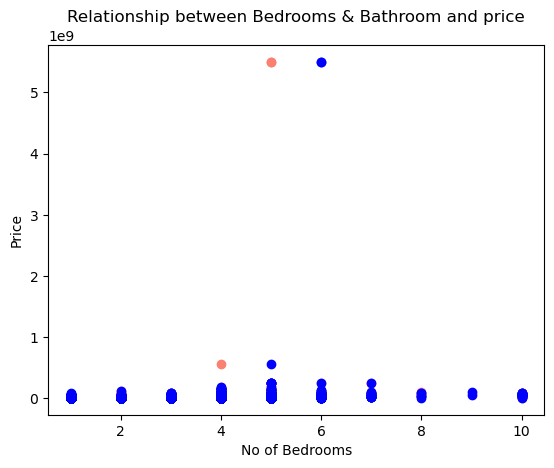

In [58]:
plt.scatter(df.bedroom, df.price, c= ["salmon"])
plt.scatter(df.bathroom, df.price, c= ["blue"])
plt.xlabel("No of Bedrooms")
plt.ylabel("Price")
plt.title("Relationship between Bedrooms & Bathroom and price");


### Feature Engineering
The Dataset needs to be tuned a bit. looking at the graph above we have outliers in the bathroom and bedroom columns in relation with price.
I would the try these things:

1. Check all features correlation and see how they react with price
2. Check all features correlation and see how they correlate with each other
3. When training, I would log transform the price, as the values are very high, which would normally distort the distribution.
4. Merge Bedroom and Bathroom together by creating a label called bed_bath_combo 
5. Change Town, state, and Apartment to numerical data
7. Train with some feature labels and score and notice the difference in score as you add more.

In [5]:
df

,bedroom,parking_lot,bathroom,toilets,town,state,serviced,extras,Stable Electricity,title,price
0,6,0,6,7,Ikoyi,Lagos,0,0,0,Detached Duplex,250000000.0
1,3,0,3,4,Ikoyi,Lagos,0,0,0,Flat Apartment,40000000.0
2,3,0,3,4,Ikoyi,Lagos,0,0,0,Flat Apartment,20000000.0
3,3,0,3,4,Ikoyi,Lagos,0,0,0,Flat Apartment,20000000.0
4,3,0,3,4,Ikoyi,Lagos,0,0,0,Flat Apartment,20000000.0
...,...,...,...,...,...,...,...,...,...,...,...
7265,1,1,1,1,Oshodi,Lagos,0,8,0,Mini flat Apartment,800000.0
7266,5,0,6,6,Ikoyi,Lagos,1,0,0,Terraced Duplex,20000000.0
7267,4,0,5,5,Ikoyi,Lagos,0,0,0,Terraced Duplex,40000000.0
7268,2,0,2,3,Lekki,Lagos,0,0,0,Blocks Of Flats,8500000.0


## 1. Check all features correlation and see how they react with price

In [20]:
df.toilets.corr(df.price),df.bathroom.corr(df.price),df.bedroom.corr(df.price),df.parking_lot.corr(df.price), df.serviced.corr(df.price), df["Stable Electricity"].corr(df.price), df.extras.corr(df.price)

(0.10176752060501294,
 0.1043241791414707,
 0.10404757638242472,
 0.0010152869950673527,
 0.0011294085965157293,
 0.005306998880795691,
 -0.006856952860338849)

Conclusion : They all have bad correlation  with price. It will need some fine tuning

## 2. Check all features correlation and see how they correlate with each other

In [63]:
df[["bedroom", "bathroom", "toilets"]].corr() # checking how bedrooms, bathrooms and toilet relate to each other

,bedroom,bathroom,toilets
bedroom,1.000000,0.934951,0.948503
bathroom,0.934951,1.000000,0.945275
toilets,0.948503,0.945275,1.000000


In [65]:
df[["parking_lot", "extras", "serviced", "Stable Electricity"]].corr()

,parking_lot,extras,serviced,Stable Electricity
parking_lot,1.000000,0.601462,0.030129,0.516772
extras,0.601462,1.000000,0.000805,0.559628
serviced,0.030129,0.000805,1.000000,0.018923
Stable Electricity,0.516772,0.559628,0.018923,1.000000


In [66]:
df[["parking_lot", "bedroom","Stable Electricity"]].corr()

,parking_lot,bedroom,Stable Electricity
parking_lot,1.000000,0.055845,0.516772
bedroom,0.055845,1.000000,0.048461
Stable Electricity,0.516772,0.048461,1.000000


Conclusion : 
* Bedroom, Bathroom and Toilet have very good correlation with each other (as it should)
* Serviced has the worst correlation with all of them. is it important then?...
  

### Creating an object that will evaulate and score a model

In [6]:
class HouseEval:
    def __init__(self, x_train, y_train, x_test, y_test, model):
        '''
        Initialises features and target variables
        It takes training and testing data
        ''' 
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = model
        self.model.fit(self.x_train, self.y_train)
        
    def score_model(self):
         np.random.seed(42)
        # Returns the score in R^2 log-space
         return self.model.score(self.x_test, self.y_test)
        
    def metrics(self):
        np.random.seed(42)

        y_preds_log = self.model.predict(self.x_test)
        
        # Convert back to actual price scale
        y_preds = np.expm1(y_preds_log)
        y_true = np.expm1(self.y_test)
        
        # scoring methods
        metrics = {
            "mse": mean_squared_error(y_true, y_preds),
            "mae": mean_absolute_error(y_true, y_preds),
            "mape": mean_absolute_percentage_error(y_true, y_preds),
            "r2": r2_score(y_true, y_preds)
        }

        df_compare = pd.DataFrame({
            "y_true" : y_true,
            "y_preds" : y_preds
        })
        return metrics, df_compare
    def tune(self,n_estimators=[100], max_depth=[None], min_samples_split=[2], min_samples_leaf=[1], max_leaf_nodes=[None],n_jobs=[None], cv=None, verbose=1):
        '''
        This uses GridSearchCV to tune hyperparamters.
        it takes a list of paramter value of each paramter in the model used (in this case RandomForestRegressor)

        n_estimator : Number of trees in the forest. More trees means more decison, slower performance though.
        too much treees can cause overfitting.

        max_depth : Max depth of a tree. Limits how deep trees can go in the decision tree; shallower trees help avoid overfitting.
        Default is none.

        min_samples_split : This sets the minimum number of samples required to split an internal node.
        If min_samples_split=4, a node must have at least 4 rows to try splitting into two child nodes.
        Analogy: You don’t want to make a decision based on just 2 customers. Use more data to decide.

        min_samples_leaf: Minimum number of samples allowed in a leaf node (the last split before prediction).
        E.g., If only one sample of a $500K house exists, 
        we don’t want the model to create a rule only for that — set min_samples_leaf=2 to generalize better.

        max_features: Number (or fraction) of features to consider when looking for the best split.
        
        max_leaf_nodes: Limits the maximum number of leaf nodes in a tree.
        It’s like saying: “Don’t learn more than 10 different price rules.” 

        min_impurity_decrease :A split will only be made if the reduction in impurity (error) is greater than this threshold.
        If splitting based on garage only improves prediction by 0.0001, it won’t split unless min_impurity_decrease < 0.0001

        n_jobs: Number of CPU cores to use (-1 = all)

        cv: cross validation for grid search
        '''
   
        grid = {
            "n_estimators" : n_estimators,
            "max_depth" : max_depth,
            "min_samples_split" : min_samples_split,
            "min_samples_leaf" : min_samples_leaf,
            "max_leaf_nodes" : max_leaf_nodes,
            "n_jobs" : n_jobs
        }
        gridCv = GridSearchCV(self.model, grid, cv=cv, verbose=verbose)
        gridCv.fit(self.x_train, self.y_train)
        self.model = gridCv
        return gridCv.best_params_, gridCv.score(self.x_test, self.y_test)
        
        
        
        
        

### Choosing the right preprocessor
Now before trying to turn non-numerical data, we should note the preprocessors to us. After deliberating, this 3 would be used
1. OneHotEncoder for states (8 unique values) to aviod creating too many columns
2. Label Encoding for towns (83 unique values)
3. Frequency encoding for title (34 unique values)

In [7]:
len(df.state.unique()),len(df.town.unique()), len(df.title.unique())

(8, 83, 34)

## 5. Change Town, state, and Apartment to numerical data

#### Always split your data into training and test before processing

In [8]:
x = df.drop("price", axis=1) # Feature labels
y = df.price # Target label1

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5816, 10), (1454, 10), (5816,), (1454,))

In [10]:

# features that need to be transformed
town_feat = ["town"]
state_feat = ["state"]
title_feat = ["title"]

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
ce_encoder = ce.CountEncoder()


transformer = ColumnTransformer(
    [("ordinal_encoder", ordinal_encoder , town_feat),
    ("One_hot",one_hot , state_feat),
    ("fEncoder",ce_encoder , title_feat)]
   ,remainder="passthrough")

# Fit and transform
x_train_encoded = transformer.fit_transform(x_train)
x_test_encoded = transformer.transform(x_test)

# Get the original columns used
all_input_columns = transformer.feature_names_in_

# Get passthrough columns
explicitly_transformed_cols = town_feat + state_feat + title_feat
passthrough_columns = [col for col in all_input_columns if col not in explicitly_transformed_cols]

# Get output feature names from transformers
ordinal_feature_names = town_feat
ohe_feature_names = transformer.named_transformers_["One_hot"].get_feature_names_out(state_feat).tolist()
count_encoded_names = title_feat  # CountEncoder keeps column name

# Combine all into final list
final_columns = ordinal_feature_names + ohe_feature_names + count_encoded_names + passthrough_columns
final_columns

['town',
 'state_Abuja',
 'state_Delta',
 'state_Enugu',
 'state_Kaduna',
 'state_Lagos',
 'state_Ogun',
 'state_Oyo',
 'state_Rivers',
 'title',
 'bedroom',
 'parking_lot',
 'bathroom',
 'toilets',
 'serviced',
 'extras',
 'Stable Electricity']

In [11]:
x_train_df = pd.DataFrame(x_train_encoded, columns=final_columns).astype(int)
x_test_df = pd.DataFrame(x_test_encoded, columns=final_columns).astype(int)

In [12]:
x_train_df

,town,state_Abuja,state_Delta,state_Enugu,state_Kaduna,state_Lagos,state_Ogun,state_Oyo,state_Rivers,title,bedroom,parking_lot,bathroom,toilets,serviced,extras,Stable Electricity
0,48,0,0,0,0,1,0,0,0,578,4,1,4,5,0,11,0
1,48,0,0,0,0,1,0,0,0,94,1,0,1,1,0,0,0
2,48,0,0,0,0,1,0,0,0,68,1,0,1,2,0,12,0
3,3,0,0,0,0,1,0,0,0,578,4,1,5,5,0,8,1
4,63,0,0,0,0,1,0,0,0,709,3,1,3,3,0,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5811,30,0,0,0,0,1,0,0,0,521,1,1,1,1,0,8,0
5812,10,0,0,0,0,1,0,0,0,521,1,0,1,2,0,0,0
5813,48,0,0,0,0,1,0,0,0,602,4,0,4,4,0,0,0
5814,35,0,0,0,0,1,0,0,0,68,1,0,1,2,0,0,0


## 3. Log the Price

In [13]:
y_train, y_test = np.log1p(y_train), np.log1p(y_test)

In [16]:
x_train_df.bedroom

0       1
1       2
2       2
3       4
4       1
       ..
5811    1
5812    2
5813    1
5814    4
5815    4
Name: bedroom, Length: 5816, dtype: int64

### 6. Train with some feature labels and score and notice the difference in score as you add more.

##### 1. Training with bathrooms, bedrooms and toilets

In [15]:
x_train_split_bd = x_train_df[["bedroom", "bathroom", "toilets"]]
x_test_split_bd = x_test_df[["bedroom", "bathroom", "toilets"]]

In [39]:
x_train_split_bd

,bedroom,bathroom,toilets
0,2,2,2
1,5,5,6
2,3,3,4
3,3,3,4
4,3,3,4
...,...,...,...
5811,4,4,5
5812,4,4,4
5813,2,2,3
5814,2,2,2


In [18]:
model_1 = HouseEval(x_train_split_bd, y_train, x_test_split_bd,y_test, RandomForestRegressor())

In [19]:
model_1.score_model()

0.4642346939060681

In [17]:
model_1.metrics()

{'mse': 2.0511726343017616e+16,
 'mae': 12181073.888710447,
 'mape': 1.885897784982917}

##### 2. Training with states, title, serviced, Stable Electricity and extras

In [22]:
x_train_split_ex = x_train_df.drop(["bedroom","bathroom", "toilets"], axis=1)
x_test_split_ex = x_test_df.drop(["bedroom","bathroom", "toilets"], axis=1)

In [23]:
model_2 = HouseEval(x_train_split_ex, y_train, x_test_split_ex,y_test, RandomForestRegressor())

In [24]:
model_2.score_model()

0.08154128720748521

In [25]:
model_2.metrics()

{'mse': 1.9275008652512044e+16,
 'mae': 9053033.768603481,
 'mape': 1.0746146052764052}

##### 3. Training with all features

In [10]:
model_3 = HouseEval(x_train_df, y_train, x_test_df,y_test, RandomForestRegressor())

In [11]:
model_3.score_model()

0.8318006490114822

In [12]:
model_3.metrics()

({'mse': 441713270320118.1,
  'mae': 4464972.145906002,
  'mape': 0.5300568223008247,
  'r2': -0.5372908223454851},
           y_true       y_preds
 2933   1200000.0  1.453476e+06
 6850  13500000.0  8.654757e+06
 2934   4000000.0  1.462490e+06
 900    5000000.0  5.160526e+06
 6438  35000000.0  3.523851e+07
 ...          ...           ...
 2707  20000000.0  5.186928e+07
 6365  80000000.0  6.318016e+07
 1739  11000000.0  3.339196e+07
 2277  20000000.0  1.576357e+07
 7218   3000000.0  3.144134e+06
 
 [1454 rows x 2 columns])

### 4. Merge Bedroom and Bathroom together by creating a label called bed_bath_combo

In [14]:
x_train_edit = x_train_df
x_test_edit = x_test_df

x_train_edit["bath_bedroom_combo"] = x_train_edit.bathroom * x_train_edit.bedroom
x_test_edit["bath_bedroom_combo"] = x_test_edit.bathroom * x_test_edit.bedroom


In [14]:
model_4 = HouseEval(x_train_edit, y_train, x_test_edit,y_test, RandomForestRegressor())
model_4.score_model()

0.8327510521854609

In [15]:
model_4.metrics()

({'mse': 93219026316739.84,
  'mae': 3864433.676260863,
  'mape': 0.5506283270453945,
  'r2': 0.5886776931561277},
           y_true       y_preds
 6190   3500000.0  3.283242e+06
 1787   6000000.0  1.067793e+07
 2883  12000000.0  9.065772e+06
 4     20000000.0  2.769064e+07
 7123  15000000.0  1.582474e+07
 ...          ...           ...
 5622   5000000.0  8.041201e+06
 3376  20000000.0  2.500000e+07
 2426  13500000.0  9.102090e+06
 4782  40000000.0  2.725854e+07
 2761  40000000.0  3.278376e+07
 
 [1454 rows x 2 columns])

#### More Feature engineerinng...
I have tried and the model is still not up to par. I have looked at the dataset again and came with this conclusion


1. A serviced house (1) doesnt increase price drastically, but it definitelty ups the price, but very very small. because of the prescence of bathroom, toilets, bedroom, location and extras, serviced power is limited. the issue is, adding it to another column might not show how important it is,  but multipltying will lead to the question of, what happens to a house not serviced (0).
2. Stable electricity also has a small correelation to price. Although, that should not be the case considering this is Nigeria. adding it with another column might be the best bet. but how and with which?
3. Extras is supposed to have a good correlation with price, but when using the corr function, i get a very bad score (-0.006). extras refers to the extra things the house comes with like jacuzzi, cinema rooms. granted the extras are not very specific for instance, a house with 5 extras like garden, small hut, study room, security, and street light should not be worth more than a house with 3 extras of cinema room, elevator, and a gym. i hope you get the concept. what should be done with this? removed? I hope not. Worked on again? almost impossible. Added to another column to give it strength? i hope so
4. Parking lot also does have a bad correlation with price, i feel it is not strong on its own.


My solution??
1. For Serviced and Stable electricity
im going to create a house_lux_combo which will be `bedroom + bathroom + toilets * serviced * (stable electricity * 2)`

2. For extras, i'lll create the extras bucket and add thee column 
3. For parking i'll use the parking ratio `df["parking_ratio"] = df["parking_lot"] / (df["bedroom"] + 1)` 

In [15]:
x_train_edit_df = x_train_df

In [16]:
# 1. For Serviced and Stable electricity im going to create a house_lux_combo which will be bedroom + bathroom + toilets * serviced * (stable electricity * 2)
x_train_edit_df["house_lux_combo"] = (x_train_df.bedroom + x_train_df.bathroom + x_train_df.toilets) * (x_train_df["Stable Electricity"] * 2)

# 2. For extras, i'lll create the extras bucket and add the column 
x_train_edit_df["extras_bucket"] = pd.cut(x_train_edit_df["extras"], bins=[-1, 2, 4, 6, 16], labels=["low", "medium", "high", "very_high"])
x_train_edit_df = pd.get_dummies(x_train_edit_df, columns=["extras_bucket"], dtype=int)

# 3. For parking i'll use the parking ratio `df["parking_ratio"] = df["parking_lot"] / (df["bedroom"] + 1)` 
x_train_edit_df["parking_ratio"] =  x_train_edit_df["parking_lot"] / (x_train_edit_df["bedroom"] + 1)


In [31]:
x_test_edit_df = x_test_df

In [32]:
# 1. For Serviced and Stable electricity im going to create a house_lux_combo which will be bedroom + bathroom + toilets * serviced * (stable electricity * 2)
x_test_edit_df["house_lux_combo"] = (x_test_df.bedroom + x_test_df.bathroom + x_test_df.toilets) * (x_test_df["Stable Electricity"] * 2)

# 2. For extras, i'lll create the extras bucket and add the column 
x_test_edit_df["extras_bucket"] = pd.cut(x_test_edit_df["extras"], bins=[-1, 2, 4, 6, 16], labels=["low", "medium", "high", "very_high"])
x_test_edit_df = pd.get_dummies(x_test_edit_df, columns=["extras_bucket"], dtype=int)

# 3. For parking i'll use the parking ratio `df["parking_ratio"] = df["parking_lot"] / (df["bedroom"] + 1)` 
x_test_edit_df["parking_ratio"] =  x_test_edit_df["parking_lot"] / (x_test_edit_df["bedroom"] + 1)

In [33]:
x_test_edit_df

,town,state_Abuja,state_Delta,state_Enugu,state_Kaduna,state_Lagos,state_Ogun,state_Oyo,state_Rivers,title,...,serviced,extras,Stable Electricity,bath_bedroom_combo,house_lux_combo,extras_bucket_low,extras_bucket_medium,extras_bucket_high,extras_bucket_very_high,parking_ratio
0,77,0,0,0,0,1,0,0,0,182,...,0,17,1,1,6,0,0,0,0,0.000000
1,48,0,0,0,0,1,0,0,0,1725,...,0,0,0,16,0,1,0,0,0,0.000000
2,48,0,0,0,0,1,0,0,0,578,...,0,0,0,64,0,1,0,0,0,0.000000
3,72,0,0,0,0,1,0,0,0,122,...,0,0,0,9,0,1,0,0,0,0.000000
4,48,0,0,0,0,1,0,0,0,521,...,0,0,0,2,0,1,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,3,0,0,0,0,1,0,0,0,521,...,0,15,1,2,10,0,0,0,1,0.000000
1450,0,0,0,0,0,1,0,0,0,1725,...,0,15,0,6,0,0,0,0,1,0.333333
1451,72,0,0,0,0,1,0,0,0,1725,...,0,13,1,2,10,0,0,0,1,0.000000
1452,33,0,0,0,0,1,0,0,0,1725,...,0,12,0,6,0,0,0,0,1,0.000000


In [34]:
model_5 = HouseEval(x_train_edit_df, y_train,x_test_edit_df, y_test, RandomForestRegressor())

In [35]:
model_5.score_model()

0.805098670565677

In [36]:
model_5.metrics()

({'mse': 2.0018208524003396e+16,
  'mae': 7558986.89944978,
  'mape': 1.2898861916023434,
  'r2': 0.04211732173194527},
           y_true       y_preds
 5958   1300000.0  6.663122e+05
 5549  10000000.0  1.896871e+07
 6203  30000000.0  3.226936e+07
 3985  12000000.0  3.497449e+07
 1224   4000000.0  4.153896e+06
 ...          ...           ...
 492    1500000.0  1.493991e+06
 3651   1700000.0  1.572968e+06
 3084  10000000.0  1.297057e+07
 3583   4500000.0  7.449877e+06
 1557   2300000.0  3.009465e+06
 
 [1454 rows x 2 columns])

## Tunning Hyperparamter

I am going to tune hyperparamters to see if i can get a good score, the goal of this model is to get an *R^2* score of 0.9 on the log scale and 0.8 on the original price scale

In [37]:
n_estimators = np.arange(10,400,40)
max_depth = [None, 3,5,7,2]
min_samples_split = np.arange(2,5,1)
min_samples_leaf = np.arange(1,5,1)
max_leaf_node = [None,10,5, 20]
n_jobs = [1]
cv=5

In [38]:
np.random.seed(42)
model_5.tune(n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_leaf_nodes=max_leaf_node,
    n_jobs=n_jobs,
    cv=cv)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


({'max_depth': None,
  'max_leaf_nodes': None,
  'min_samples_leaf': 2,
  'min_samples_split': 4,
  'n_estimators': 370,
  'n_jobs': 1},
 0.8051074909404442)

In [40]:
metrics_dict, y_preds = model_5.metrics()